In [1]:
# Codeblock 1
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm

In [2]:
# Codeblock 2
IMAGE_SIZE     = 28     #(1)
NUM_CHANNELS   = 1      #(2)

BATCH_SIZE     = 2
NUM_EPOCHS     = 10
LEARNING_RATE  = 0.001
NUM_TIMESTEPS  = 1000   #(3)
BETA_START     = 0.0001 #(4)
BETA_END       = 0.02   #(5)
TIME_EMBED_DIM = 32     #(6)
DEVICE = torch.device("cuda" if torch.cuda.is_available else "cpu")  #(7)
DEVICE

device(type='cuda')

In [5]:
# Codeblock 3
class TimeEmbedding(nn.Module):
  def forward(self):
          time = torch.arange(NUM_TIMESTEPS, device=DEVICE).reshape(NUM_TIMESTEPS, 1)  #(1)
          #print(f"time\t\t: {time.shape}")
          
          i = torch.arange(0, TIME_EMBED_DIM, 2, device=DEVICE)
          denominator = torch.pow(10000, i/TIME_EMBED_DIM)
          #print(f"denominator\t: {denominator.shape}")
          
          even_time_embed = torch.sin(time/denominator)  #(1)
          odd_time_embed  = torch.cos(time/denominator)  #(2)
          #print(f"even_time_embed\t: {even_time_embed.shape}")
          #print(f"odd_time_embed\t: {odd_time_embed.shape}")
          
          stacked = torch.stack([even_time_embed, odd_time_embed], dim=2)  #(3)
          #print(f"stacked\t\t: {stacked.shape}")
          time_embed = torch.flatten(stacked, start_dim=1, end_dim=2)  #(4)
          #print(f"time_embed\t: {time_embed.shape}")
          
          return time_embed

In [4]:
# Codeblock 4
time_embed_test = TimeEmbedding()
out_test = time_embed_test()

time		: torch.Size([1000, 1])
denominator	: torch.Size([16])
even_time_embed	: torch.Size([1000, 16])
odd_time_embed	: torch.Size([1000, 16])
stacked		: torch.Size([1000, 16, 2])
time_embed	: torch.Size([1000, 32])


In [8]:
# Codeblock 5a
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):  #(1)
        super().__init__()
        
        self.conv_0 = nn.Conv2d(in_channels=in_channels,  #(2)
                                out_channels=out_channels, 
                                kernel_size=3, 
                                bias=False, 
                                padding=1)
        self.bn_0 = nn.BatchNorm2d(num_features=out_channels)  #(3)
        
        self.time_embedding = TimeEmbedding()  #(4)
        self.linear = nn.Linear(in_features=TIME_EMBED_DIM,  #(5)
                                out_features=out_channels)
        
        self.conv_1 = nn.Conv2d(in_channels=out_channels,  #(6)
                                out_channels=out_channels, 
                                kernel_size=3, 
                                bias=False, 
                                padding=1)
        self.bn_1 = nn.BatchNorm2d(num_features=out_channels)  #(7)
        
        self.relu = nn.ReLU(inplace=True)  #(8)

# Codeblock 5b
    def forward(self, x, t):  #(1)
        #print(f'images\t\t\t: {x.size()}')
        #print(f'timesteps\t\t: {t.size()}, {t}')
        
        x = self.conv_0(x)  #(2)
        x = self.bn_0(x)    #(3)
        x = self.relu(x)    #(4)
        #print(f'\nafter first conv\t: {x.size()}')
        
        time_embed = self.time_embedding()[t]      #(5)
        #print(f'\ntime_embed\t\t: {time_embed.size()}')
        
        time_embed = self.linear(time_embed)       #(6)
        #print(f'time_embed after linear\t: {time_embed.size()}')
        
        time_embed = time_embed[:, :, None, None]  #(7)
        #print(f'time_embed expanded\t: {time_embed.size()}')
        
        x = x + time_embed  #(8)
        #print(f'\nafter summation\t\t: {x.size()}')
        
        x = self.conv_1(x)  #(9)
        x = self.bn_1(x)    #(10)
        x = self.relu(x)    #(11)
        #print(f'after second conv\t: {x.size()}')
        
        return x

In [7]:
# Codeblock 6
double_conv_test = DoubleConv(in_channels=1, out_channels=64).to(DEVICE)  #(1)

x_test = torch.randn((BATCH_SIZE, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)).to(DEVICE)  #(2)
t_test = torch.randint(0, NUM_TIMESTEPS, (BATCH_SIZE,)).to(DEVICE)  #(3)

out_test = double_conv_test(x_test, t_test)  #(4)

images			: torch.Size([2, 1, 28, 28])
timesteps		: torch.Size([2]), tensor([781, 636], device='cuda:0')

after first conv	: torch.Size([2, 64, 28, 28])

time_embed		: torch.Size([2, 32])
time_embed after linear	: torch.Size([2, 64])
time_embed expanded	: torch.Size([2, 64, 1, 1])

after summation		: torch.Size([2, 64, 28, 28])
after second conv	: torch.Size([2, 64, 28, 28])


In [11]:
# Codeblock 7
class DownSample(nn.Module):
    def __init__(self, in_channels, out_channels):  #(1)
        super().__init__()
        
        self.double_conv = DoubleConv(in_channels=in_channels,  #(2)
                                      out_channels=out_channels)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)    #(3)
    
    def forward(self, x, t):  #(4)
        #print(f'original\t\t: {x.size()}')
        #print(f'timesteps\t\t: {t.size()}, {t}')
        
        convolved = self.double_conv(x, t)   #(5)
        #print(f'\nafter double conv\t: {convolved.size()}')
        
        maxpooled = self.maxpool(convolved)  #(6)
        #print(f'after pooling\t\t: {maxpooled.size()}')
        
        return convolved, maxpooled          #(7)

In [10]:
# Codeblock 8
down_sample_test = DownSample(in_channels=1, out_channels=64).to(DEVICE)

x_test = torch.randn((BATCH_SIZE, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)).to(DEVICE)
t_test = torch.randint(0, NUM_TIMESTEPS, (BATCH_SIZE,)).to(DEVICE)

out_test = down_sample_test(x_test, t_test)

original		: torch.Size([2, 1, 28, 28])
timesteps		: torch.Size([2]), tensor([858, 930], device='cuda:0')

after double conv	: torch.Size([2, 64, 28, 28])
after pooling		: torch.Size([2, 64, 14, 14])


In [14]:
# Codeblock 9
class UpSample(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        
        self.conv_transpose = nn.ConvTranspose2d(in_channels=in_channels,  #(1)
                                                 out_channels=out_channels, 
                                                 kernel_size=2, stride=2)  #(2)
        self.double_conv = DoubleConv(in_channels=in_channels,  #(3)
                                      out_channels=out_channels)
        
    def forward(self, x, t, connection):  #(4)
        #print(f'original\t\t: {x.size()}')
        #print(f'timesteps\t\t: {t.size()}, {t}')
        #print(f'connection\t\t: {connection.size()}')
        
        x = self.conv_transpose(x)  #(5)
        #print(f'\nafter conv transpose\t: {x.size()}')
        
        x = torch.cat([x, connection], dim=1)  #(6)
        #print(f'after concat\t\t: {x.size()}')
        
        x = self.double_conv(x, t)  #(7)
        #print(f'after double conv\t: {x.size()}')
        
        return x

In [13]:
# Codeblock 10
up_sample_test = UpSample(in_channels=128, out_channels=64).to(DEVICE)

x_test = torch.randn((BATCH_SIZE, 128, 14, 14)).to(DEVICE)
t_test = torch.randint(0, NUM_TIMESTEPS, (BATCH_SIZE,)).to(DEVICE)
connection_test = torch.randn((BATCH_SIZE, 64, 28, 28)).to(DEVICE)

out_test = up_sample_test(x_test, t_test, connection_test)

original		: torch.Size([2, 128, 14, 14])
timesteps		: torch.Size([2]), tensor([678, 126], device='cuda:0')
connection		: torch.Size([2, 64, 28, 28])

after conv transpose	: torch.Size([2, 64, 28, 28])
after concat		: torch.Size([2, 128, 28, 28])
after double conv	: torch.Size([2, 64, 28, 28])


In [17]:
# Codeblock 11a
class UNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.downsample_0 = DownSample(in_channels=NUM_CHANNELS,  #(1) 
                                       out_channels=64)
        self.downsample_1 = DownSample(in_channels=64,            #(2)
                                       out_channels=128)
        
        self.bottleneck   = DoubleConv(in_channels=128,           #(3) 
                                       out_channels=256)
        
        self.upsample_0   = UpSample(in_channels=256,             #(4) 
                                     out_channels=128)
        self.upsample_1   = UpSample(in_channels=128,             #(5)
                                     out_channels=64)
        
        self.output = nn.Conv2d(in_channels=64,                   #(6)
                                out_channels=NUM_CHANNELS, 
                                kernel_size=1)

# Codeblock 11b
    def forward(self, x, t):  #(1)
            #print(f'original\t\t: {x.size()}')
            #print(f'timesteps\t\t: {t.size()}, {t}')
            
            convolved_0, maxpooled_0 = self.downsample_0(x, t)
            #print(f'\nmaxpooled_0\t\t: {maxpooled_0.size()}')
            
            convolved_1, maxpooled_1 = self.downsample_1(maxpooled_0, t)
            #print(f'maxpooled_1\t\t: {maxpooled_1.size()}')
            
            x = self.bottleneck(maxpooled_1, t)
            #print(f'after bottleneck\t: {x.size()}')
    
            upsampled_0 = self.upsample_0(x, t, convolved_1)
            #print(f'upsampled_0\t\t: {upsampled_0.size()}')
            
            upsampled_1 = self.upsample_1(upsampled_0, t, convolved_0)
            #print(f'upsampled_1\t\t: {upsampled_1.size()}')
            
            x = self.output(upsampled_1)
            #print(f'final output\t\t: {x.size()}')
            
            return x

In [16]:
# Codeblock 12
unet_test = UNet().to(DEVICE)

x_test = torch.randn((BATCH_SIZE, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)).to(DEVICE)
t_test = torch.randint(0, NUM_TIMESTEPS, (BATCH_SIZE,)).to(DEVICE)

out_test = unet_test(x_test, t_test)

original		: torch.Size([2, 1, 28, 28])
timesteps		: torch.Size([2]), tensor([282, 459], device='cuda:0')

maxpooled_0		: torch.Size([2, 64, 14, 14])
maxpooled_1		: torch.Size([2, 128, 7, 7])
after bottleneck	: torch.Size([2, 256, 7, 7])
upsampled_0		: torch.Size([2, 128, 14, 14])
upsampled_1		: torch.Size([2, 64, 28, 28])
final output		: torch.Size([2, 1, 28, 28])


In [18]:
# Codeblock 13
transform = transforms.Compose([  #(1)
    transforms.ToTensor(),        #(2)
    transforms.Normalize((0.5,), (0.5,))  #(3)
])

mnist_dataset = datasets.MNIST(   #(4)
    root='./data', 
    train=True,           #(5)
    download=True, 
    transform=transform   #(6)
)

loader = DataLoader(mnist_dataset,  #(7)
                    batch_size=BATCH_SIZE,
                    drop_last=True, 
                    shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 53038497.37it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 1792107.20it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 14414954.18it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6917403.33it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [19]:
# Codeblock 14
images, labels = next(iter(loader))

print('images\t\t:', images.shape)
print('labels\t\t:', labels.shape)
print('min value\t:', images.min())
print('max value\t:', images.max())

images		: torch.Size([2, 1, 28, 28])
labels		: torch.Size([2])
min value	: tensor(-1.)
max value	: tensor(1.)


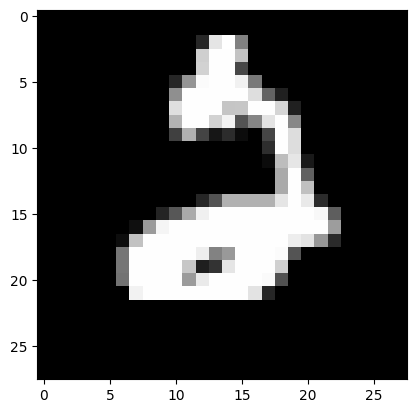

In [20]:
# Codeblock 15   
plt.imshow(images[0].squeeze(), cmap='gray')
plt.show()

In [21]:
# Codeblock 16a
class NoiseScheduler:
    def __init__(self):
        self.betas = torch.linspace(BETA_START, BETA_END, NUM_TIMESTEPS)  #(1)
        self.alphas = 1. - self.betas
        self.alphas_cum_prod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alphas_cum_prod = torch.sqrt(self.alphas_cum_prod)
        self.sqrt_one_minus_alphas_cum_prod = torch.sqrt(1. - self.alphas_cum_prod)

# Codeblock 16b
    def forward_diffusion(self, original, noise, t):
        sqrt_alphas_cum_prod_t = self.sqrt_alphas_cum_prod[t]
        sqrt_alphas_cum_prod_t = sqrt_alphas_cum_prod_t.to(DEVICE).view(-1, 1, 1, 1)  #(1)
        
        sqrt_one_minus_alphas_cum_prod_t = self.sqrt_one_minus_alphas_cum_prod[t]
        sqrt_one_minus_alphas_cum_prod_t = sqrt_one_minus_alphas_cum_prod_t.to(DEVICE).view(-1, 1, 1, 1)  #(2)
        
        noisy_image = sqrt_alphas_cum_prod_t * original + sqrt_one_minus_alphas_cum_prod_t * noise  #(3)
        
        return noisy_image

# Codeblock 16c
    def backward_diffusion(self, current_image, predicted_noise, t):  #(1)
        denoised_image = (current_image - (self.sqrt_one_minus_alphas_cum_prod[t] * predicted_noise)) / self.sqrt_alphas_cum_prod[t]  #(2)
        denoised_image = 2 * (denoised_image - denoised_image.min()) / (denoised_image.max() - denoised_image.min()) - 1  #(3)
        
        current_prediction = current_image - ((self.betas[t] * predicted_noise) / (self.sqrt_one_minus_alphas_cum_prod[t]))  #(4)
        current_prediction = current_prediction / torch.sqrt(self.alphas[t])  #(5)
        
        if t == 0:  #(6)
            return current_prediction, denoised_image
        
        else:
            variance = (1 - self.alphas_cum_prod[t-1]) / (1. - self.alphas_cum_prod[t])  #(7)
            variance = variance * self.betas[t]  #(8)
            sigma = variance ** 0.5
            z = torch.randn(current_image.shape).to(DEVICE)
            current_prediction = current_prediction + sigma*z
            
            return current_prediction, denoised_image

In [22]:
# Codeblock 17
noise_scheduler = NoiseScheduler()

print(f'betas\t\t\t\t: {noise_scheduler.betas[:6]}')
print(f'alphas\t\t\t\t: {noise_scheduler.alphas[:6]}')
print(f'alphas_cum_prod\t\t\t: {noise_scheduler.alphas_cum_prod[:6]}')
print(f'sqrt_alphas_cum_prod\t\t: {noise_scheduler.sqrt_alphas_cum_prod[:6]}')
print(f'sqrt_one_minus_alphas_cum_prod\t: {noise_scheduler.sqrt_one_minus_alphas_cum_prod[:6]}')

betas				: tensor([1.0000e-04, 1.1992e-04, 1.3984e-04, 1.5976e-04, 1.7968e-04, 1.9960e-04])
alphas				: tensor([0.9999, 0.9999, 0.9999, 0.9998, 0.9998, 0.9998])
alphas_cum_prod			: tensor([0.9999, 0.9998, 0.9996, 0.9995, 0.9993, 0.9991])
sqrt_alphas_cum_prod		: tensor([0.9999, 0.9999, 0.9998, 0.9997, 0.9997, 0.9996])
sqrt_one_minus_alphas_cum_prod	: tensor([0.0100, 0.0148, 0.0190, 0.0228, 0.0264, 0.0300])


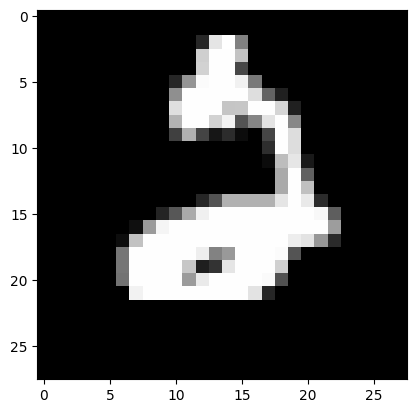

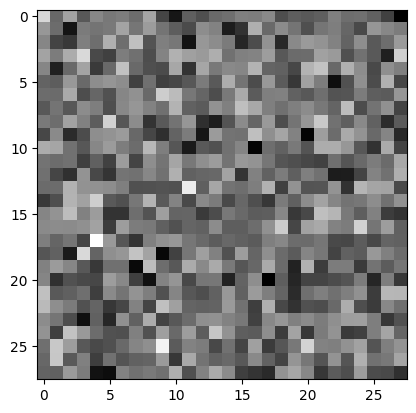

In [23]:
# Codeblock 18
image = images[0]  #(1)
noise = torch.randn_like(image)  #(2)

plt.imshow(image.squeeze(), cmap='gray')
plt.show()
plt.imshow(noise.squeeze(), cmap='gray')
plt.show()

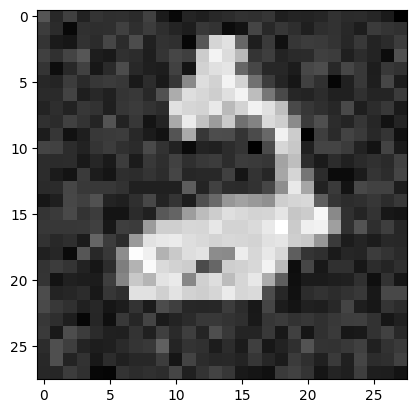

In [24]:
# Codeblock 19
noisy_image_test = noise_scheduler.forward_diffusion(image.to(DEVICE), noise.to(DEVICE), t=50)

plt.imshow(noisy_image_test[0].squeeze().cpu(), cmap='gray')
plt.show()

In [25]:
# Codeblock 20
model = UNet().to(DEVICE)
noise_scheduler = NoiseScheduler()

In [26]:
# Codeblock 21
def train():
    optimizer = Adam(model.parameters(), lr=LEARNING_RATE)  #(1)
    loss_function = nn.MSELoss()  #(2)
    losses = []
    
    for epoch in range(NUM_EPOCHS):
        print(f'Epoch no {epoch}')
        
        for images, _ in tqdm(loader):
            
            optimizer.zero_grad()

            images = images.float().to(DEVICE)  #(3)
            noise = torch.randn_like(images)  #(4)
            t = torch.randint(0, NUM_TIMESTEPS, (BATCH_SIZE,))  #(5)

            noisy_images = noise_scheduler.forward_diffusion(images, noise, t).to(DEVICE)  #(6)
            predicted_noise = model(noisy_images, t)  #(7)
            loss = loss_function(predicted_noise, noise)  #(8)
            
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

    return losses

In [ ]:
# Codeblock 22
losses = train()

Epoch no 0


100%|██████████| 30000/30000 [04:25<00:00, 112.84it/s]


Epoch no 1


100%|██████████| 30000/30000 [04:24<00:00, 113.23it/s]


Epoch no 2


100%|██████████| 30000/30000 [04:25<00:00, 113.20it/s]


Epoch no 3


100%|██████████| 30000/30000 [04:25<00:00, 113.11it/s]


Epoch no 4


100%|██████████| 30000/30000 [04:24<00:00, 113.21it/s]


Epoch no 5


100%|██████████| 30000/30000 [04:24<00:00, 113.41it/s]


Epoch no 7


100%|██████████| 30000/30000 [04:25<00:00, 112.81it/s]


Epoch no 8


100%|██████████| 30000/30000 [04:25<00:00, 113.10it/s]


Epoch no 9


 57%|█████▋    | 17015/30000 [02:30<01:53, 114.14it/s]

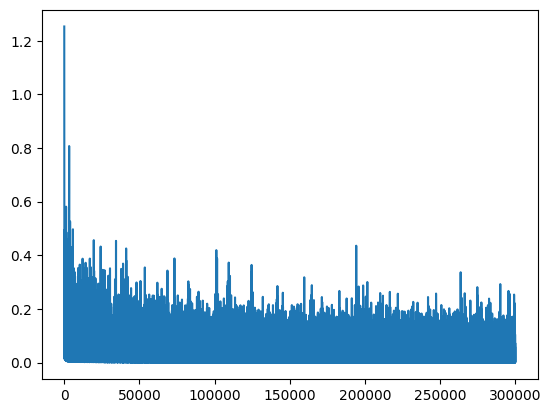

In [29]:
# Codeblock 23
plt.plot(losses)

In [30]:
# Codeblock 24
def inference():

    denoised_images = []  #(1)
    
    with torch.no_grad():  #(2)
        current_prediction = torch.randn((64, NUM_CHANNELS, IMAGE_SIZE, IMAGE_SIZE)).to(DEVICE)  #(3)
        
        for i in tqdm(reversed(range(NUM_TIMESTEPS))):  #(4)
            predicted_noise = model(current_prediction, torch.as_tensor(i).unsqueeze(0))  #(5)
            current_prediction, denoised_image = noise_scheduler.backward_diffusion(current_prediction, predicted_noise, torch.as_tensor(i))  #(6)

            if i%100 == 0:  #(7)
                denoised_images.append(denoised_image)
            
        return denoised_images

In [31]:
# Codeblock 25
denoised_images = inference()

1000it [00:07, 138.53it/s]


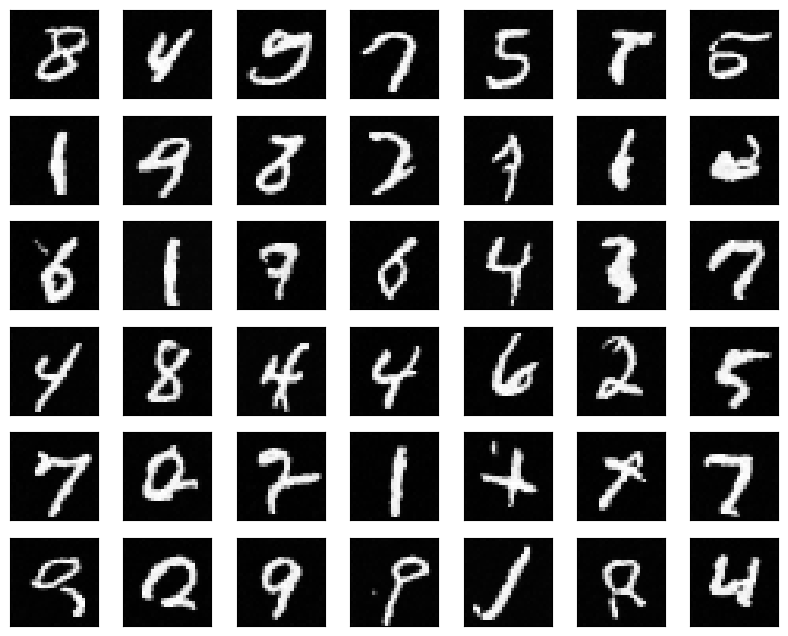

In [32]:
# Codeblock 26
fig, axes = plt.subplots(ncols=7, nrows=6, figsize=(10, 8))

counter = 0

for i in range(6):
    for j in range(7):
        axes[i,j].imshow(denoised_images[-1][counter].squeeze().detach().cpu().numpy(), cmap='gray')  #(1)
        axes[i,j].get_xaxis().set_visible(False)
        axes[i,j].get_yaxis().set_visible(False)
        counter += 1

plt.show()

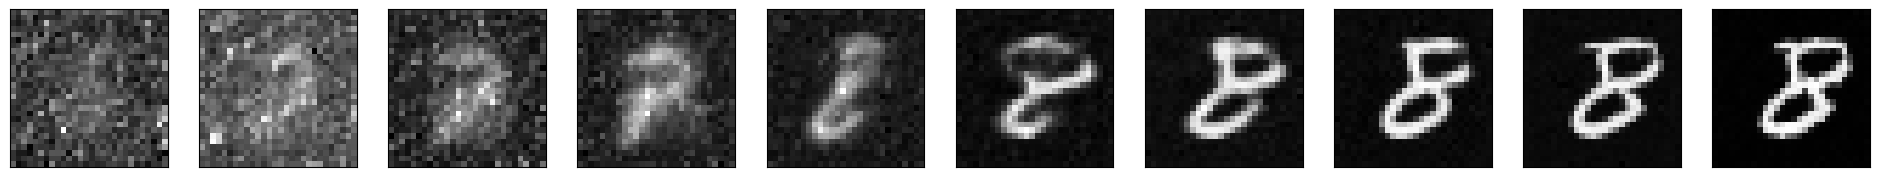

In [33]:
# Codeblock 27
fig, axes = plt.subplots(ncols=10, figsize=(24, 8))

sample_no = 0
timestep_no = 0

for i in range(10):
    axes[i].imshow(denoised_images[timestep_no][sample_no].squeeze().detach().cpu().numpy(), cmap='gray')
    axes[i].get_xaxis().set_visible(False)
    axes[i].get_yaxis().set_visible(False)
    timestep_no += 1

plt.show()